# Machine Learning for Single-Cell Biology
***

Winter Semester 2024/25<br />
Manfred Claassen, Matthias Bruhns, Jan Schleicher
<br />
***

## Assignment 1

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

import os
from utils import import_mtx_expression_data
from typing import Tuple

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("ticks")

%matplotlib inline

In [2]:
DATA_PATH = "data/"
OUTPUT_PATH = "output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Task 1

In [3]:
# Load the data
expression_data_1 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_1.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_1_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_1_genes.tsv"))
metadata_1 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_1_metadata.tsv"), sep="\t", index_col=0)

metadata_1.columns = ["CellType", "Organ"]

# If required, perform preprocessing of the data
#########################
# INSERT YOUR CODE HERE #
#########################

We are assuming that, since these cells are annotated, they were not excluded by the filtering procedures, and thus:

- have more than 500 transcripts
- are not outlier cells based on the correlation between total UMIs and the number of detected genes
- are not cells displaying a B cell phenotype

We are performing these preprocessing steps, in this exact order:

1. Remove genes that are detected in less than 10 cells.
2. Normalize the count matrix to 10000 transcripts per cell.
3. Log-transform the normalized count matrix.
4. Scaling the matrix per gene (mean 0 and variance 1).

In [4]:
print("Removing genes that are detected in less than 10 cells")

keep_genes = (expression_data_1 != 0).sum(axis = 0) >= 1

print(f"Will remove {expression_data_1.shape[1] - sum(keep_genes)} genes")
print(f"Shape before removing genes: {expression_data_1.shape}")

expression_data_1 = expression_data_1.loc[:, keep_genes]

print(f"Shape after removing genes: {expression_data_1.shape}")

Removing genes that are detected in less than 10 cells
Will remove 2825 genes
Shape before removing genes: (19302, 16254)
Shape after removing genes: (19302, 13429)


In [5]:
print("Normalizing the counts to 10000 transcripts per cell")

totals = expression_data_1.sum(axis = 1)
normalized = expression_data_1.div(totals, axis = 0) * 10_000

print("Log-transforming the normalized counts")

for c in normalized.columns:
    normalized[c] = np.log10(normalized[c].values + 0.00001)

print("Scaling the matrix")

normalized = (normalized - normalized.mean(axis = 0)) / normalized.std(axis = 0)

# Make sure the final data matrix is correct and does not contain missing values
assert not normalized.isnull().values.any()

Normalizing the counts to 10000 transcripts per cell
Log-transforming the normalized counts
Scaling the matrix


In [6]:
genes = [
    "Mad2l1", "Birc5", "Cks2", "Cks1b", "Cdca8", "Cdca3", "Mki67",
    "Tcf7", "Id3", "Cd28", "Slamf6", "Ccr7", "Sell", "Cxcr5",
    "Cx3cr1", "Tbx21", "Zeb2", "Klf2", "Klre1", "Klrk1", "Gzmb",
    "Pdcd1", "Cd160", "Cd244", "Lag3", "Eomes", "Cxcr6", "Cxcr3"
]

assert all([gene in normalized.columns for gene in genes])

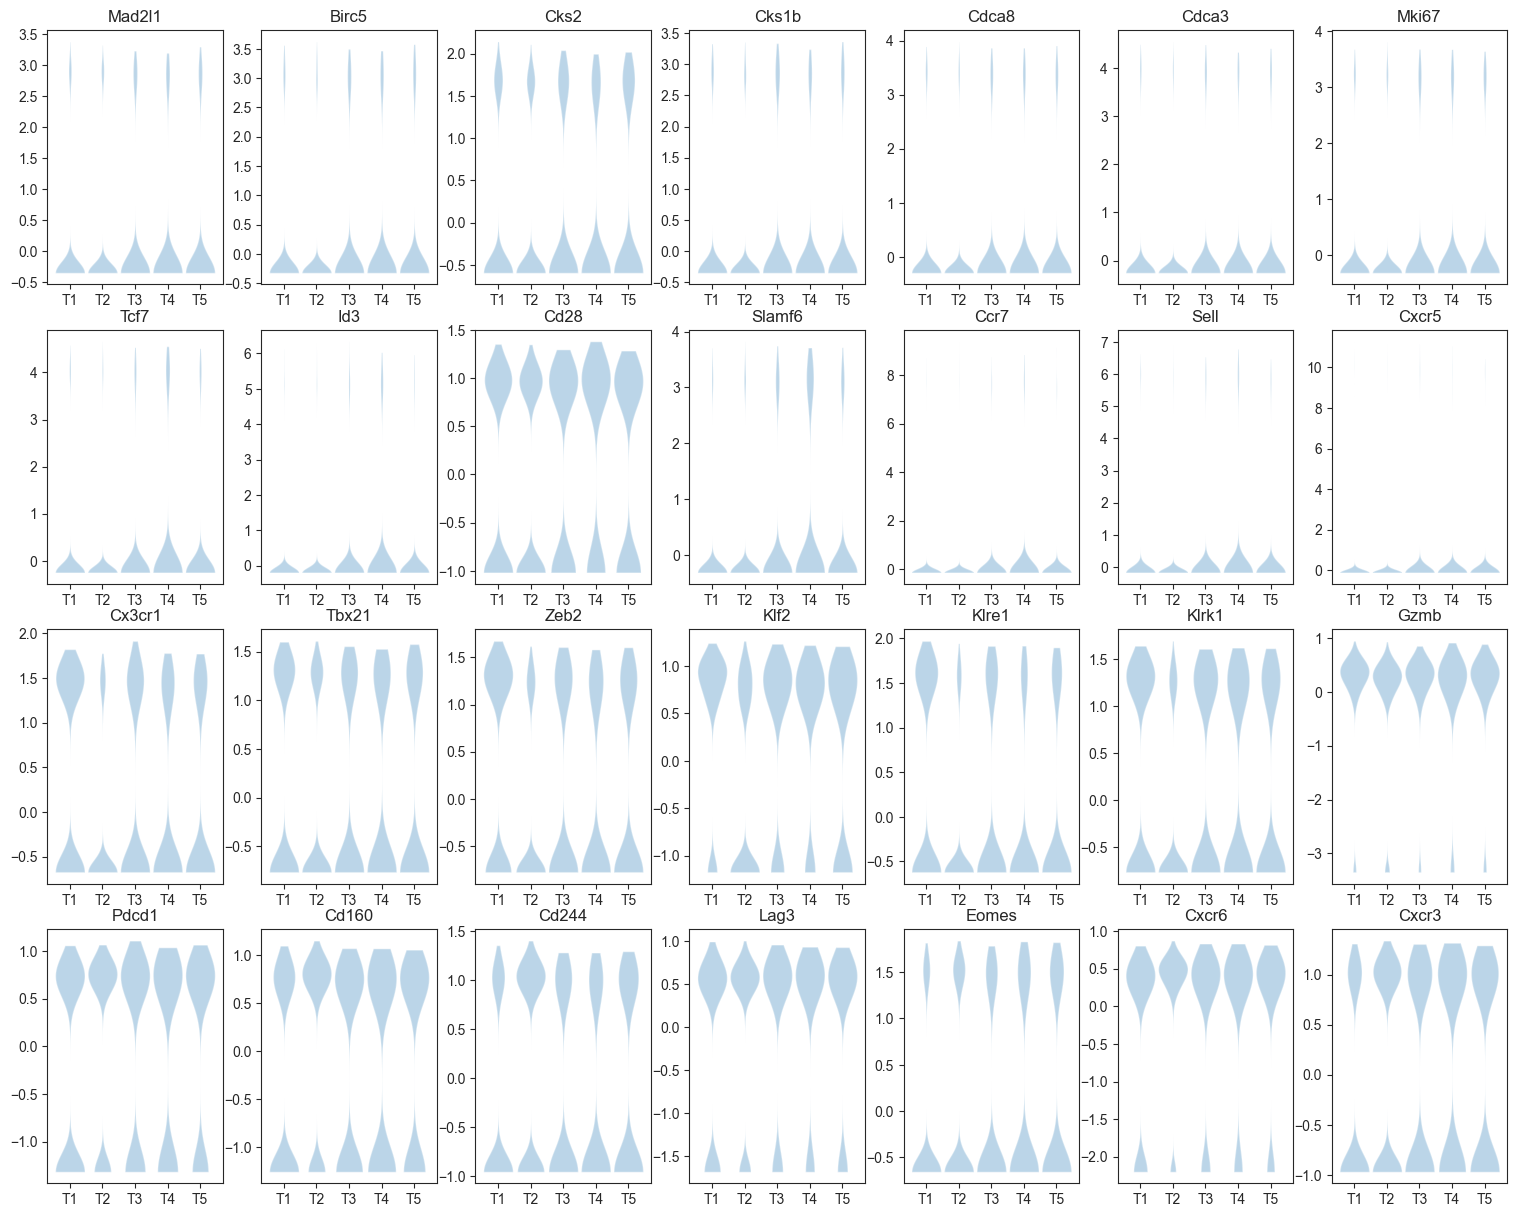

In [7]:
cell_types = metadata_1.CellType.unique().tolist()
cell_types.sort()

cell_barcodes = [metadata_1[metadata_1.CellType == cell_type].index.tolist() for cell_type in cell_types]

ncols = 7
nrows = int(len(genes) / ncols)

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 3 * nrows))

for i, gene in enumerate(genes):
    row = int(i / ncols)
    col = i % ncols

    x_pos = np.arange(0, len(cell_types))
    counts = [np.array(normalized.loc[cells, gene].tolist()) for cells in cell_barcodes]

    axs[row][col].violinplot(
        counts, x_pos,
        showmeans = False,
        showmedians = False,
        showextrema = False,
        widths = 0.9,
        points = 500
    )
    axs[row][col].set_title(gene)
    axs[row][col].set_xticks(x_pos)
    axs[row][col].set_xticklabels(cell_types)

fig.tight_layout(pad = 0.1)
plt.show()

In [11]:
def task1a_identification(expression_data: pd.DataFrame, metadata: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze the data to identify cell types and organs
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param metadata: metadata containing cell groupings and sample IDs
    :return: organ and cell type identities
    """
    organ_identity = {"A": "", "B": "", "C": "", "D": "", "E": "", "F": ""}
    cell_type_identity = {"T1": "", "T2": "", "T3": "", "T4": "", "T5": ""}

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return pd.DataFrame.from_dict(organ_identity, orient="index"),\
           pd.DataFrame.from_dict(cell_type_identity, orient="index")

In [12]:
task1a_organ_identity, task1a_cell_type_identity = task1a_identification(expression_data_1, metadata_1)

task1a_organ_identity.to_csv(os.path.join(OUTPUT_PATH, "task1a_organ_identity.txt"), sep="\t", header=False)
task1a_cell_type_identity.to_csv(os.path.join(OUTPUT_PATH, "task1a_cell_type_identity.txt"), sep="\t", header=False)

display(task1a_organ_identity)
display(task1a_cell_type_identity)

,0
A,
B,
C,
D,
E,
F,


,0
T1,
T2,
T3,
T4,
T5,


In [ ]:
# Load the data
expression_data_2 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_2.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_2_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_2_genes.tsv"))

# If required, perform preprocessing of the data
#########################
# INSERT YOUR CODE HERE #
#########################

In [ ]:
def task1b_annotation(expression_data: pd.DataFrame, expression_data_ref: pd.DataFrame, metadata_ref) -> pd.DataFrame:
    """
    Annotate each cell with its corresponding cell type
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param expression_data_ref: reference expression matrix of shape (n_cells_ref, n_genes)
    :param metadata_ref: reference metadata with n_cells_ref rows and a column containing true cell types for expression_data_ref
    :return: cell type annotations for expression_data
    """
    cell_annotations = pd.DataFrame(index=expression_data.index.values, columns=["phenotype"])

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return cell_annotations

**Please also submit the output CSV file with the annotations for Task 1b!**

In [ ]:
task1b_cell_annotations = task1b_annotation(expression_data_2, expression_data_1, metadata_1)
task1b_cell_annotations.to_csv(os.path.join(OUTPUT_PATH, "task1b_cell_annotations.txt"), sep="\t")

### Task 2

In [ ]:
cell_sequences = np.load(os.path.join(DATA_PATH, "tex_sampling.npy"))
metadata_3 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_3_metadata.txt"), sep="\t", index_col=0)
expression_data_3 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_3.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_3_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_3_genes.tsv"))

In [ ]:
def task2a_trajectory_analysis(sequences: np.ndarray, metadata: pd.DataFrame) -> Tuple[list, list]:
    """
    Identify an ordering of louvain clusters along the two trajectories
    :param sequences: numpy array of cell sequences (cell indices, corresponding to rows of metadata) of shape
    (n_sequences, n_steps)
    :param metadata: cell metadata with louvain clusters
    :return: orderings of louvain clusters along the two trajectories
    """
    upper_trajectory_louvain_ordering = []
    lower_trajectory_louvain_ordering = []

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return upper_trajectory_louvain_ordering, lower_trajectory_louvain_ordering

**Please also submit the output files with the cluster orderings for Task 2a!**

In [ ]:
task2a_upper_trajectory, task2a_lower_trajectory = task2a_trajectory_analysis(cell_sequences, metadata_3)
pd.DataFrame(task2a_upper_trajectory).to_csv(os.path.join(OUTPUT_PATH, "task2a_upper_trajectory.txt"), header=False)
pd.DataFrame(task2a_lower_trajectory).to_csv(os.path.join(OUTPUT_PATH, "task2a_lower_trajectory.txt"), header=False)

In [ ]:
def task2b_correlation_analysis(expression_data: pd.DataFrame, metadata: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the correlation of each gene's expression with sample ID
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param metadata: metadata containing sample IDs (column name sampleID)
    :return: data frame with correlation and p value for each gene
    """
    gene_correlations = pd.DataFrame(data=np.ones((expression_data.shape[1], 3)), index=expression_data.columns.values,
                                     columns=["correlation", "abs_correlation", "p_value"])

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return gene_correlations

**Please also submit the output CSV file with the correlations for Task 2b!**

In [ ]:
task2b_gene_correlations = task2b_correlation_analysis(expression_data_3, metadata_3)
task2b_gene_correlations.sort_values("abs_correlation", ascending=False).iloc[:10]\
    .to_csv(os.path.join(OUTPUT_PATH, "task2b_gene_correlations.txt"), sep="\t")

fig, ax = plt.subplots(figsize=(9, 6))
sns.scatterplot(x=task2b_gene_correlations["correlation"], y=-np.log(task2b_gene_correlations["p_value"] + 1e-15), ax=ax)
ax.set_ylabel("-log p-value");